# Proyecto 1 - Vision por computadora

### Integrantes
- Maria Marta Ramirez Gil
- Gustavo Andres Gonzalez
- Diego Alberto Leiva
- Jose Pablo Orellana

-------------------------------------------------------------------------------------------------------------

#### Problema 1

In [ ]:
import cv2
import os
import numpy as np
from skimage.filters import threshold_otsu, threshold_sauvola
from skimage.morphology import closing, square
from skimage.measure import label, regionprops
import matplotlib.pyplot as plt

In [59]:
# CARGAR IMAGENES

def cargar_imagenes(ruta_imagenes):
    imagenes = []
    groundtruths = []
    archivos = []
    
    # Verificación
    try:
        archivos = os.listdir(ruta_imagenes)
    except FileNotFoundError:
        print(f"Error: La carpeta {ruta_imagenes} no existe.")
        return [], [], []
    
    for archivo in archivos:
        if archivo.endswith("_gt.pgm"):  # Identificar ground truths
            groundtruth_path = os.path.join(ruta_imagenes, archivo)
            groundtruth = cv2.imread(groundtruth_path, cv2.IMREAD_GRAYSCALE)
            if groundtruth is not None:
                groundtruths.append(groundtruth)
            else:
                print(f"Advertencia: No se pudo cargar el archivo {groundtruth_path}")
            
            # Imagen correspondiente
            imagen_nombre = archivo.replace("_gt.pgm", ".pgm")
            imagen_path = os.path.join(ruta_imagenes, imagen_nombre)
            imagen = cv2.imread(imagen_path, cv2.IMREAD_GRAYSCALE)
            if imagen is not None:
                imagenes.append(imagen)
            else:
                print(f"Advertencia: No se pudo cargar el archivo {imagen_path}")
    
    print(f"Se encontraron {len(imagenes)} imágenes y {len(groundtruths)} ground truths.")
    
    return imagenes, groundtruths, archivos

imagenes, groundtruths, archivos = cargar_imagenes("images")

Se encontraron 20 imágenes y 20 ground truths.


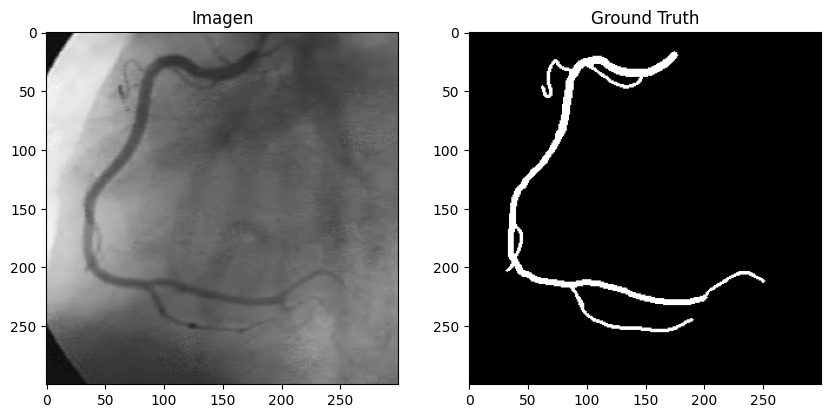

In [30]:
# MOSTRAR UNA IMAGEN Y SU GROUNDTRUTH
def mostrar_imagen_y_groundtruth(imagen, groundtruth, titulo_imagen="Imagen", titulo_gt="Ground Truth"):
    fig, ax = plt.subplots(1, 2, figsize=(10, 5))
    ax[0].imshow(imagen, cmap="gray")
    ax[0].set_title(titulo_imagen)
    ax[1].imshow(groundtruth, cmap="gray")
    ax[1].set_title(titulo_gt)
    plt.show()

mostrar_imagen_y_groundtruth(imagenes[3], groundtruths[3])

#### Binarizacion
Se utilizaran estas dos binarizaciones:

##### Binarizacion de Adaptativa:
La binarización adaptativa es una técnica de procesamiento de imágenes que convierte una imagen en escala de grises en una imagen binaria (blanco y negro) utilizando un umbral que se ajusta dinámicamente según las características locales de la imagen. Este método es útil cuando las imágenes tienen iluminación no uniforme o sombreado, ya que no depende de un solo umbral global para todas las píxeles.

Principales métodos de binarización adaptativa:

Media local (Thresholding por media): El umbral para cada píxel se calcula a partir del promedio de los píxeles en una vecindad local alrededor de ese píxel.
Mediana local: El umbral para cada píxel se calcula usando la mediana de los píxeles en una vecindad local.
Método de Gauss (Gaussian Weighted Sum): Similar a la media local, pero ponderando los píxeles cercanos al centro de la ventana de forma más significativa.

J. Sauvola (2000). Binarización adaptativa de imágenes de documentos. ScienceDirect.com. https://www-sciencedirect-com.translate.goog/science/article/abs/pii/S0031320399000552?_x_tr_sl=en&_x_tr_tl=es&_x_tr_hl=es&_x_tr_pto=tc


##### Binarizacion de Combinada:
La binarización combinada es un enfoque que utiliza múltiples técnicas de binarización y combina los resultados para obtener una imagen binaria más precisa. La idea es que diferentes métodos de binarización pueden ser más efectivos en distintas áreas de la imagen, por lo que la combinación de estos métodos puede dar como resultado una binarización más robusta y menos susceptible a errores debido a problemas como ruido o iluminación no uniforme.

Técnicas utilizadas en la binarización combinada:

Binarización de Otsu y binarización adaptativa: Combina los resultados de Otsu (para un umbral global) con la binarización adaptativa (para umbrales locales).
Binarización de bordes (Canny) y binarización tradicional (Otsu/Adaptativa): Utiliza la detección de bordes (como Canny) junto con los resultados de otros métodos de binarización para resaltar características importantes.

Sauvola, J., & Pietikainen, M. (2000). Adaptive document image binarization. Pattern Recognition, 33(2), 225-236.


In [46]:
# BINARIZACION ADAPTATIVA
def binarizacion_adaptativa(image):
    # Aplicar filtro Gaussiano para reducir ruido
    image_blur = cv2.GaussianBlur(image, (5, 5), 0)
    
    # Binarización adaptativa
    binary_adaptive = cv2.adaptiveThreshold(image_blur, 255, 
                                           cv2.ADAPTIVE_THRESH_MEAN_C, 
                                           cv2.THRESH_BINARY, 11, 2)
    return binary_adaptive


In [48]:
# BINARIZACION COMBINADA
def binarizacion_combinada(image):
    # Aplicar filtro Gaussiano para reducir ruido
    image_blur = cv2.GaussianBlur(image, (5, 5), 0)
    
    # Binarización con Otsu
    _, otsu_binary = cv2.threshold(image_blur, 0, 255, cv2.THRESH_BINARY + cv2.THRESH_OTSU)
    
    # Binarización adaptativa
    adaptive_binary = cv2.adaptiveThreshold(image_blur, 255, 
                                           cv2.ADAPTIVE_THRESH_MEAN_C, 
                                           cv2.THRESH_BINARY, 11, 2)
    
    # Binarización usando el filtro Canny (detectar bordes)
    canny_edges = cv2.Canny(image_blur, 100, 200)
    
    # Combinar las binarizaciones
    combined = cv2.bitwise_or(otsu_binary, adaptive_binary)
    combined = cv2.bitwise_or(combined, canny_edges)
    
    return combined

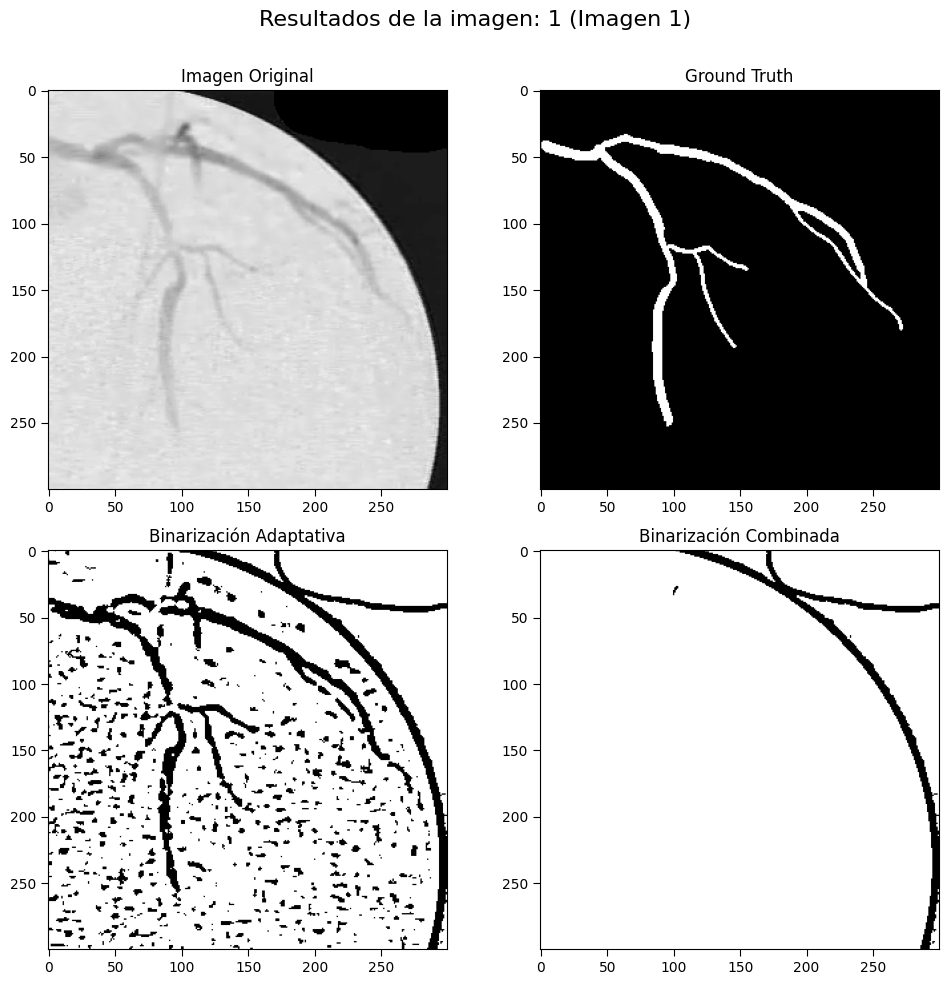

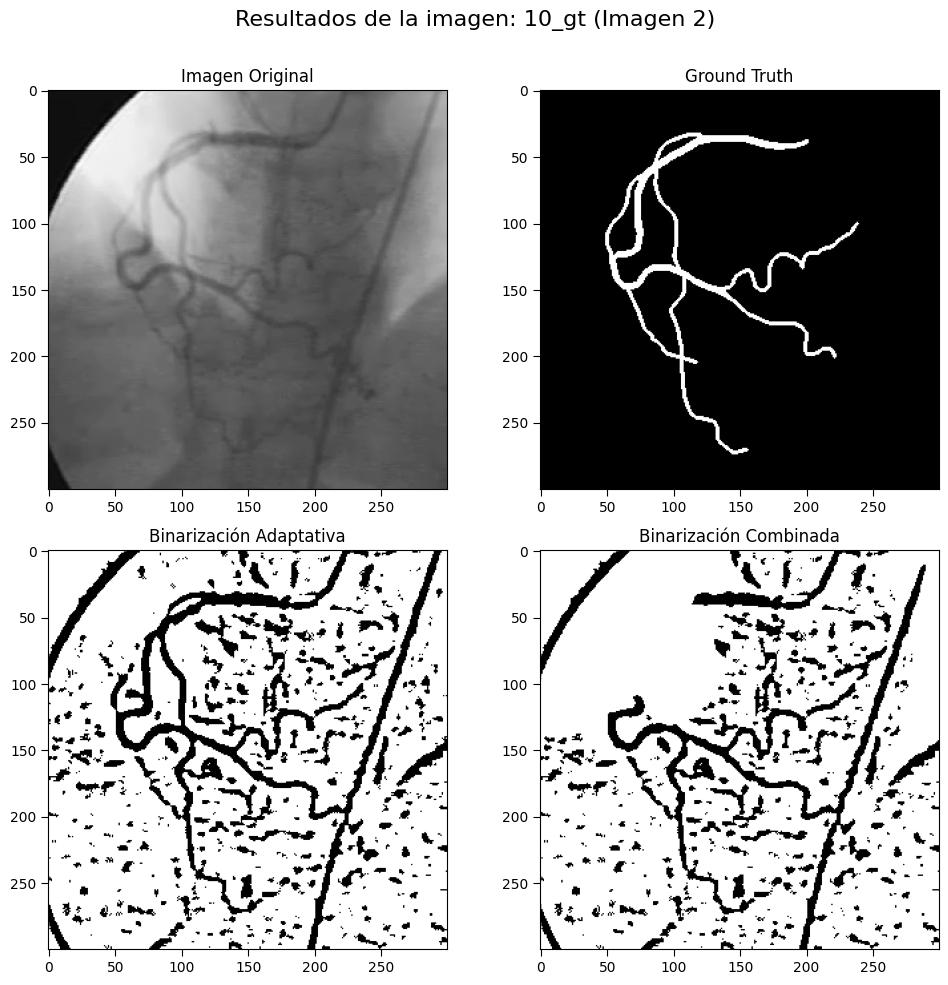

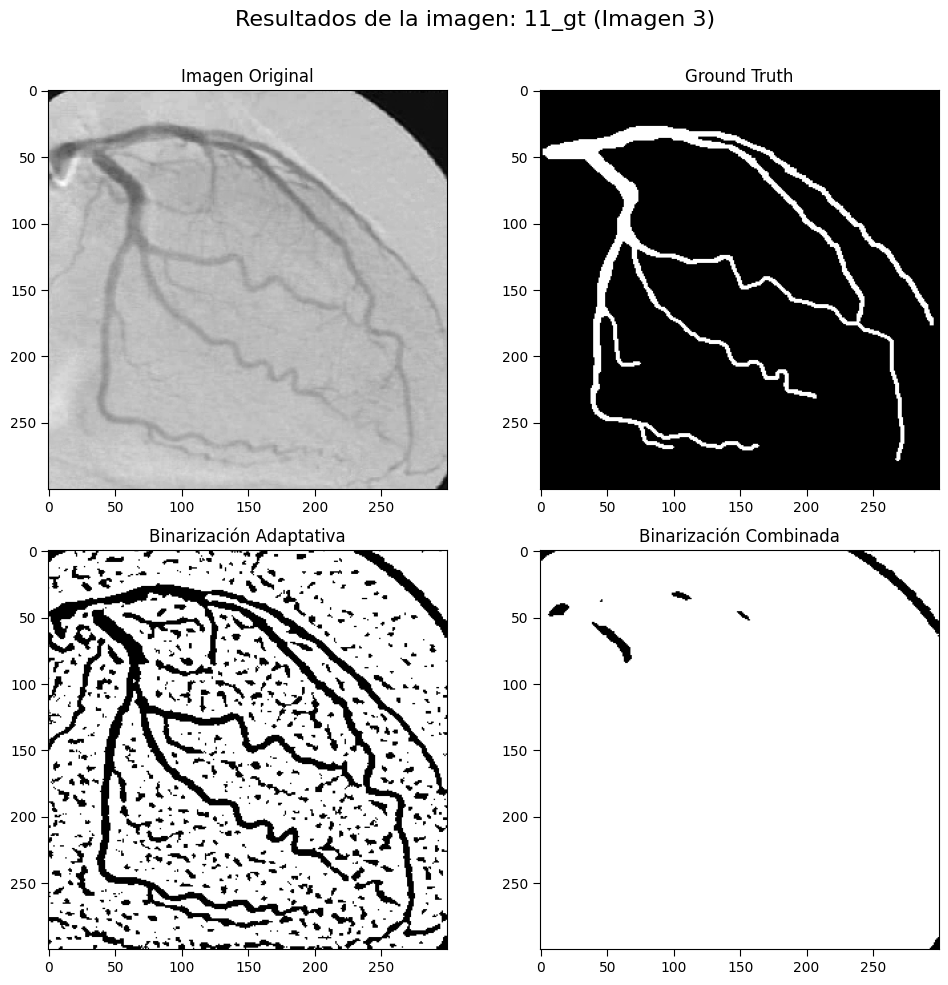

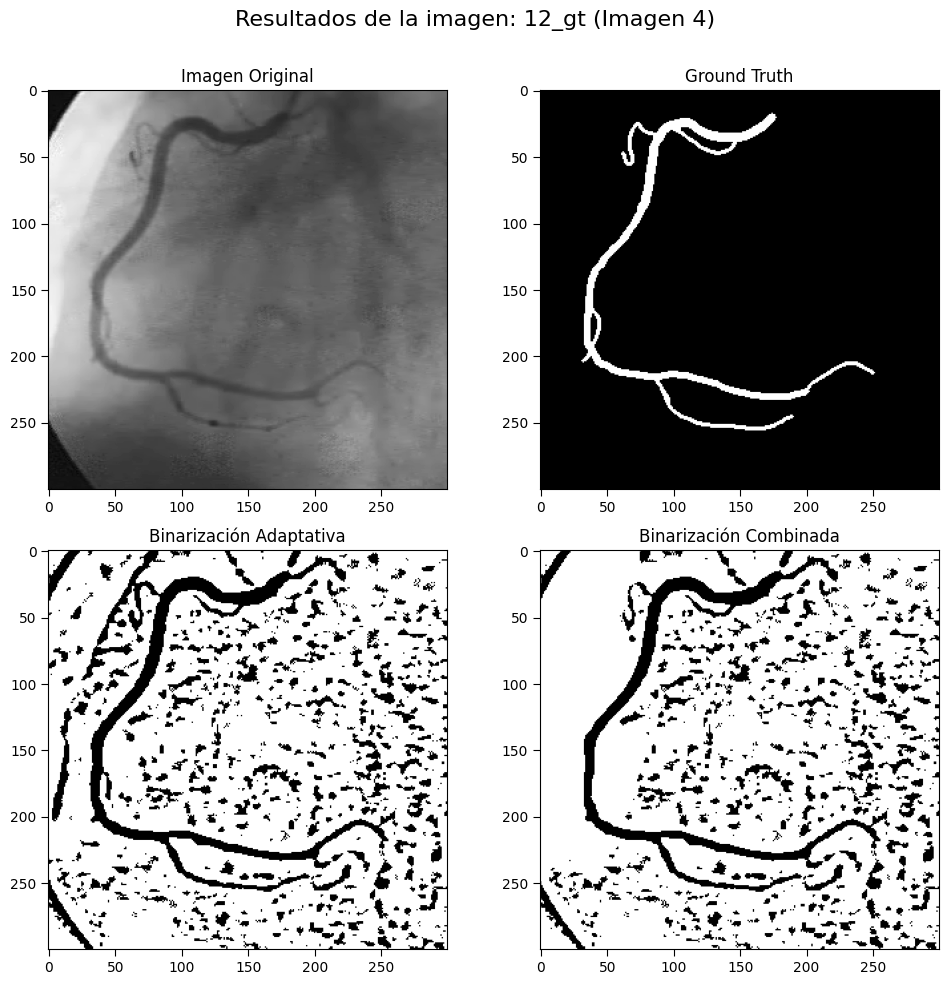

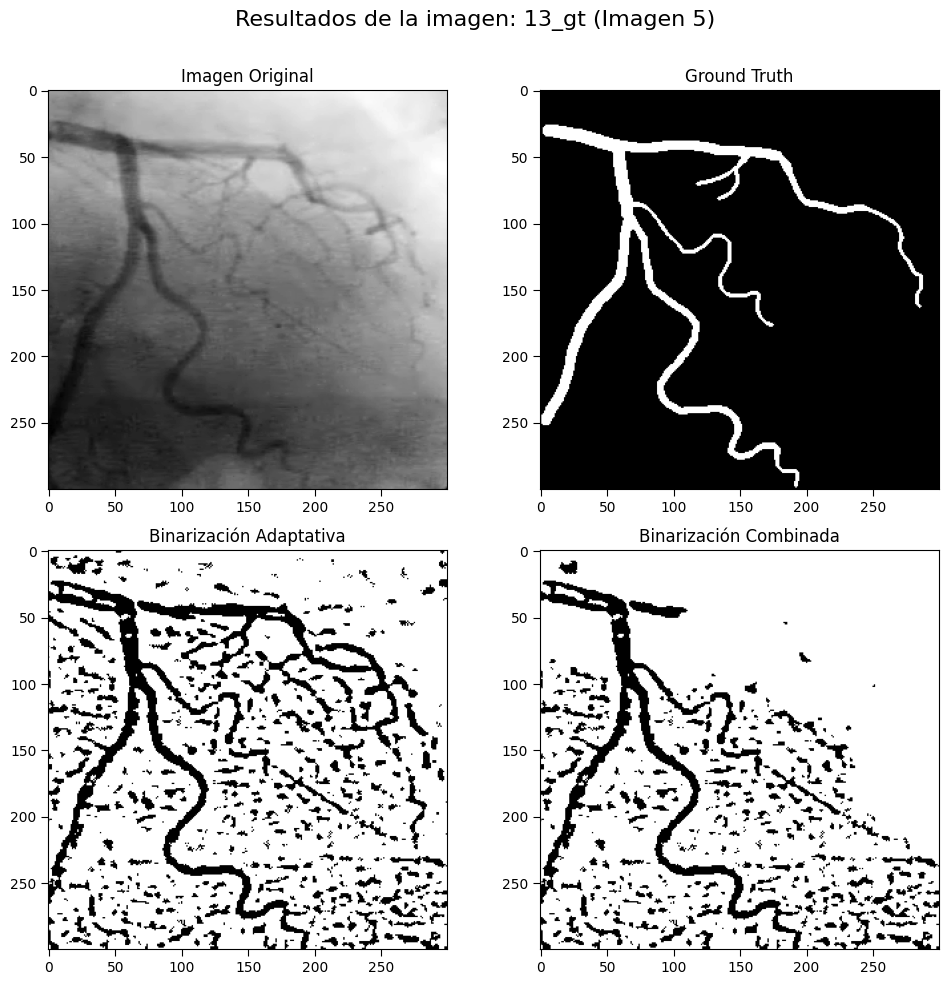

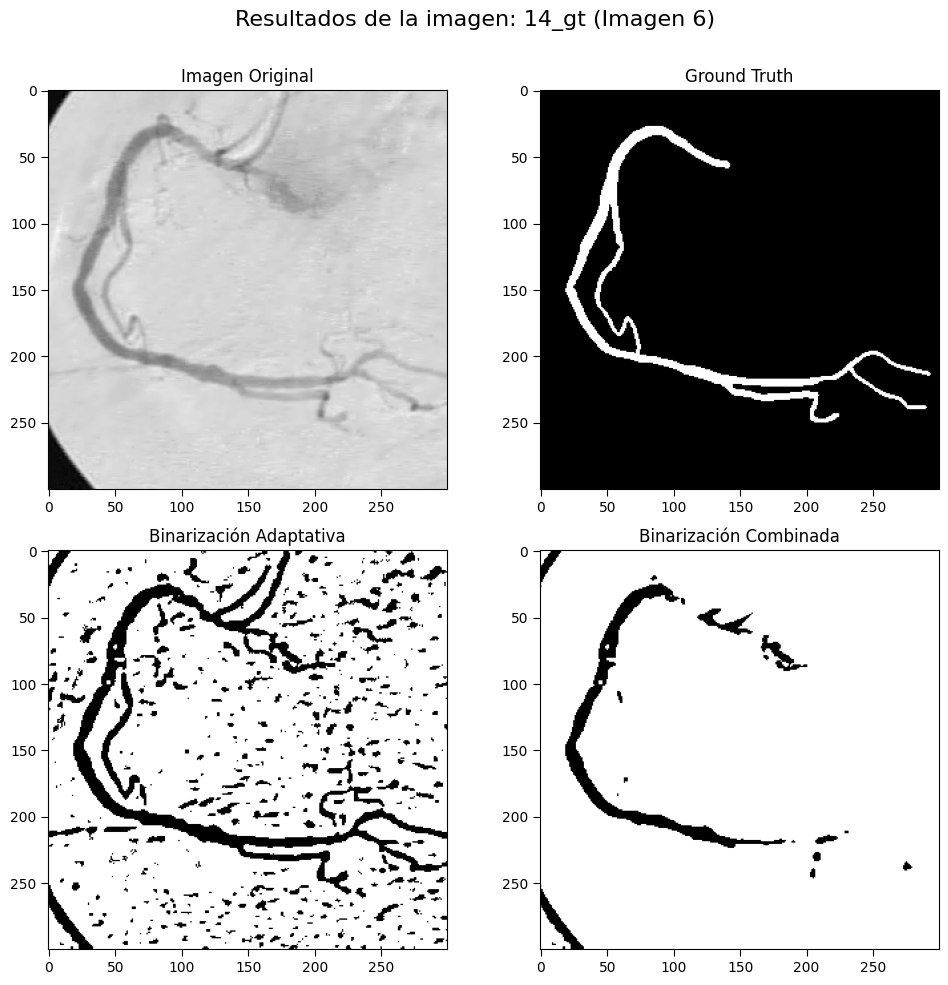

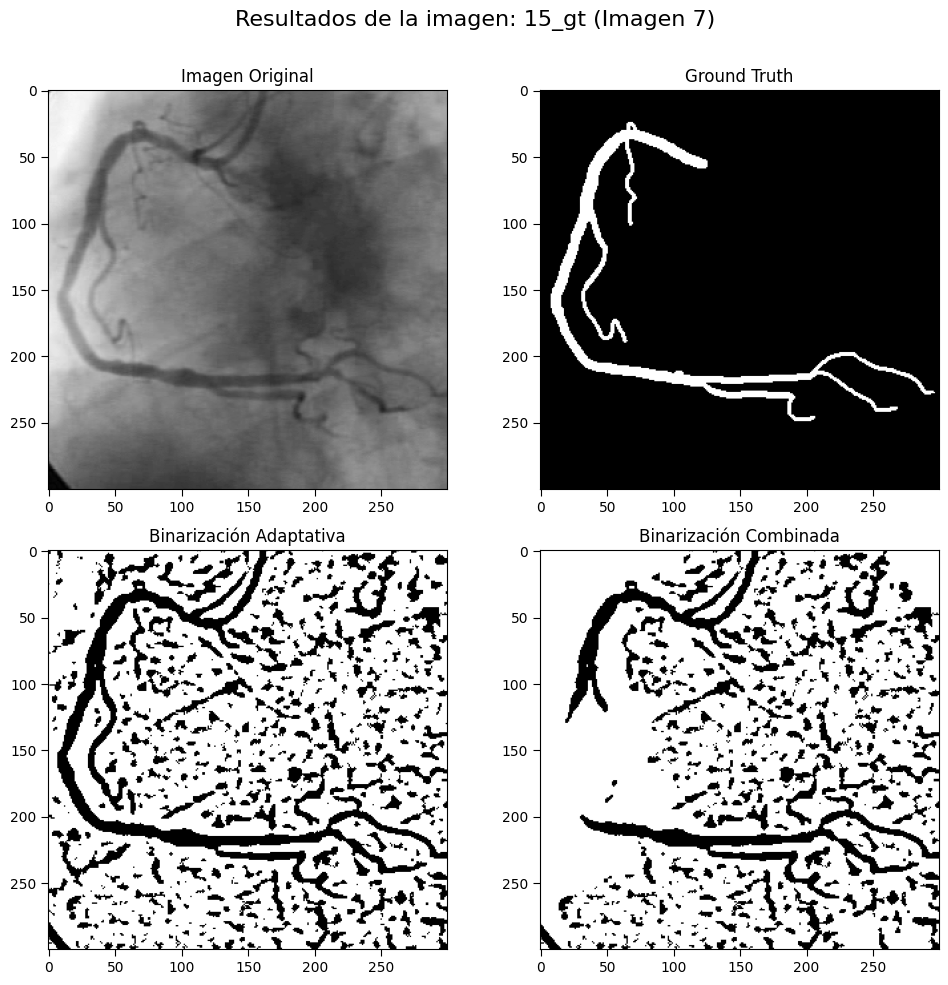

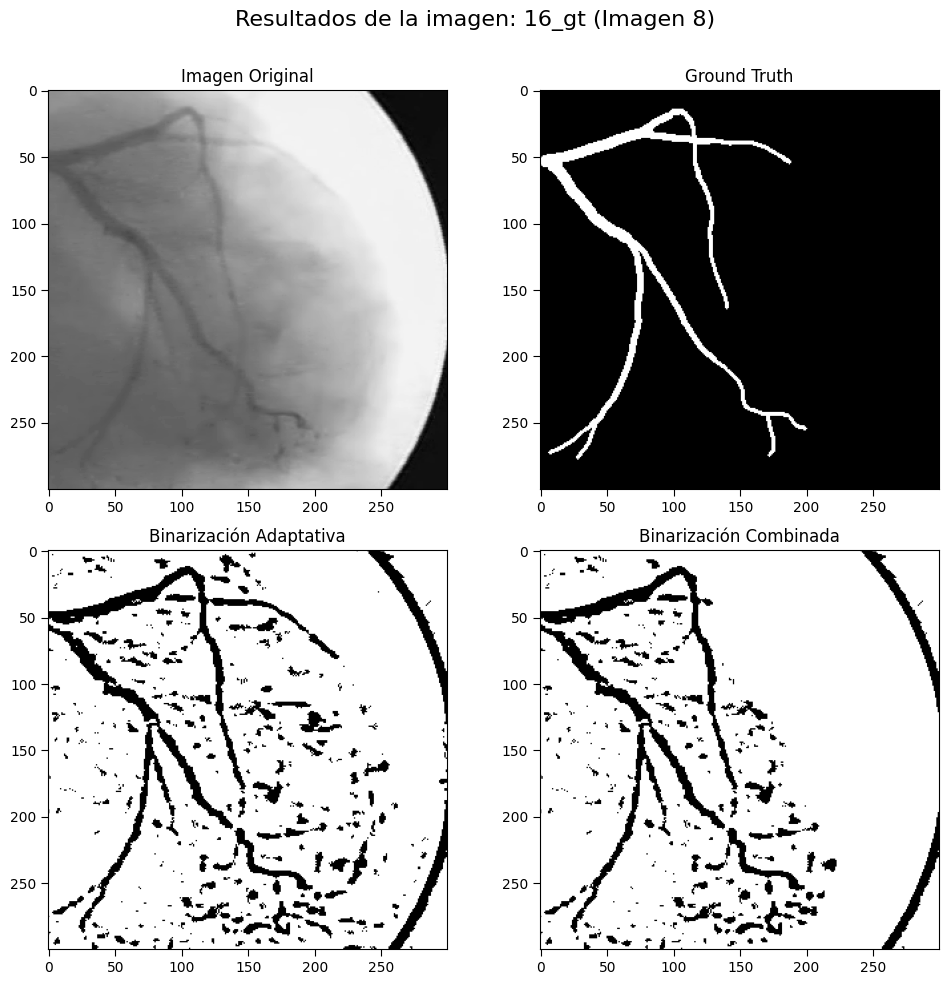

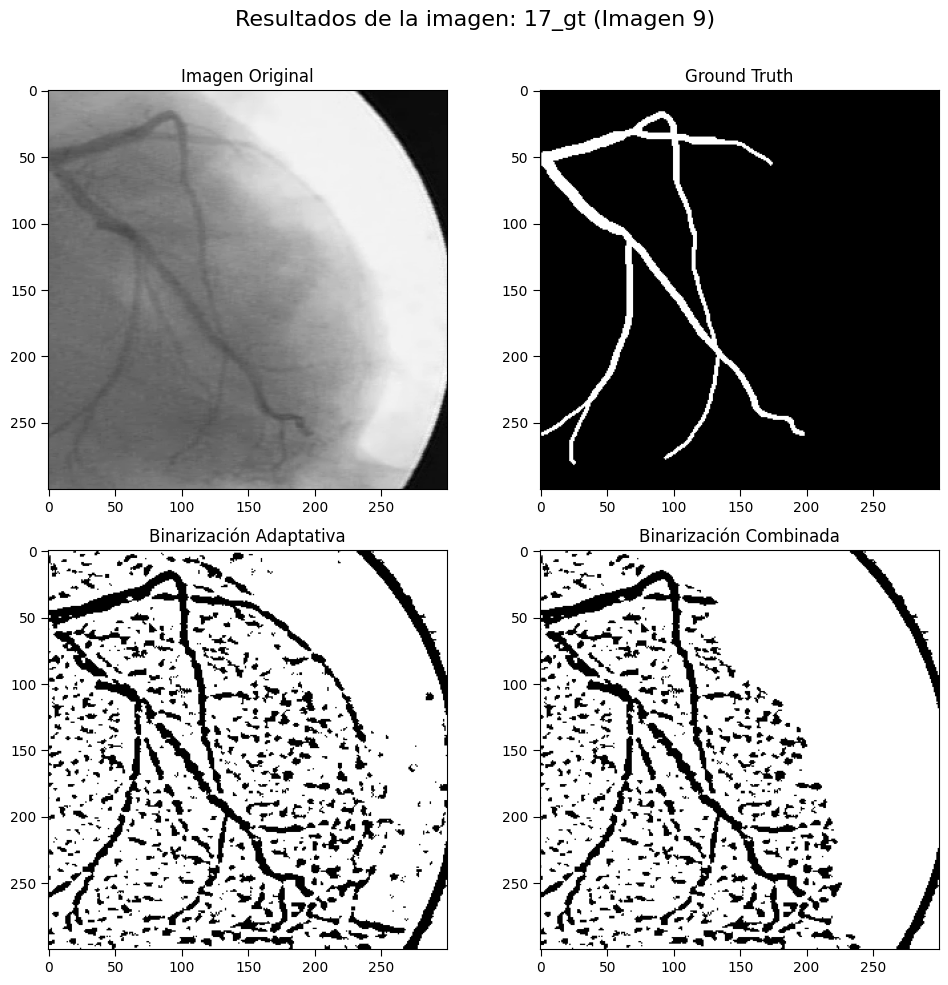

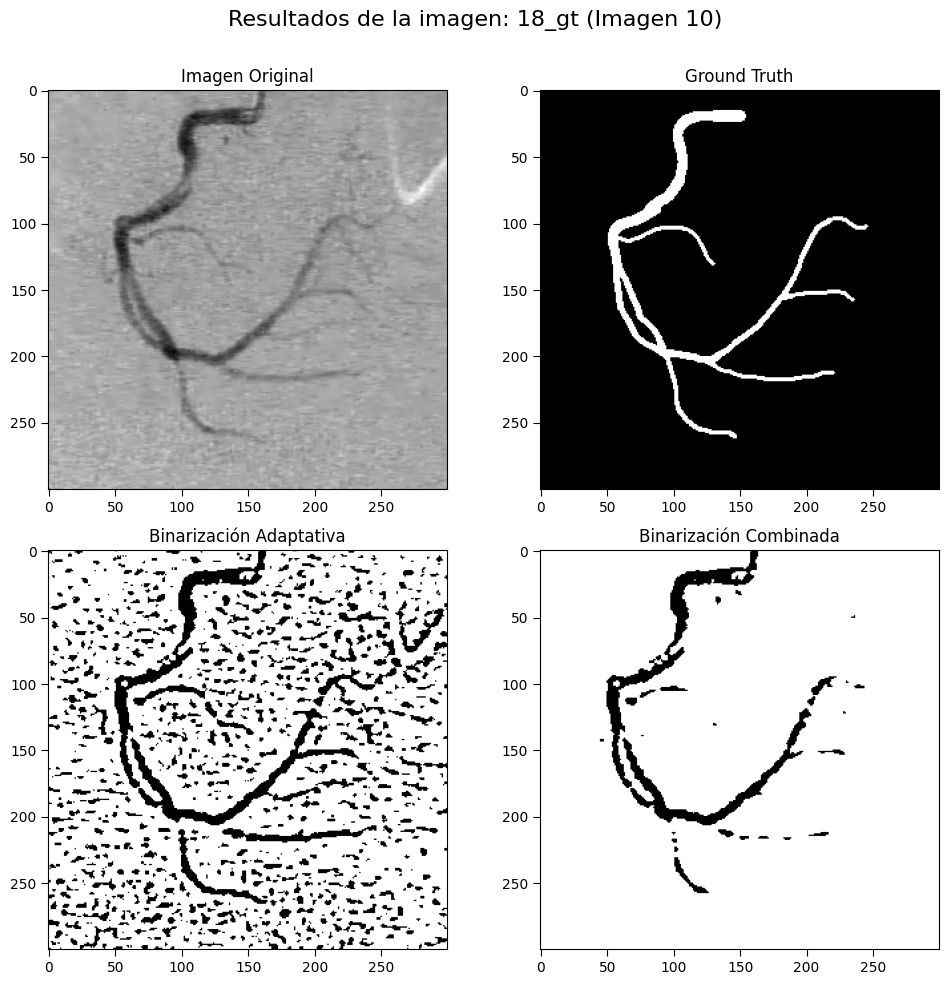

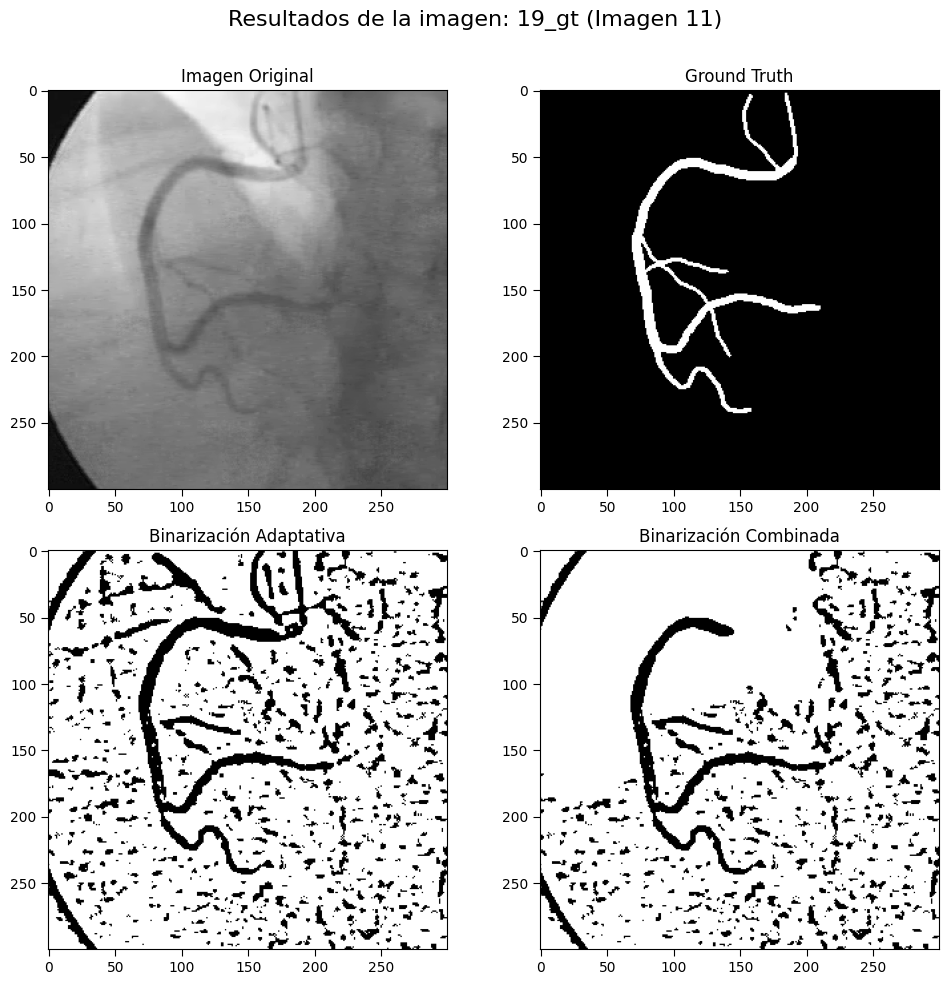

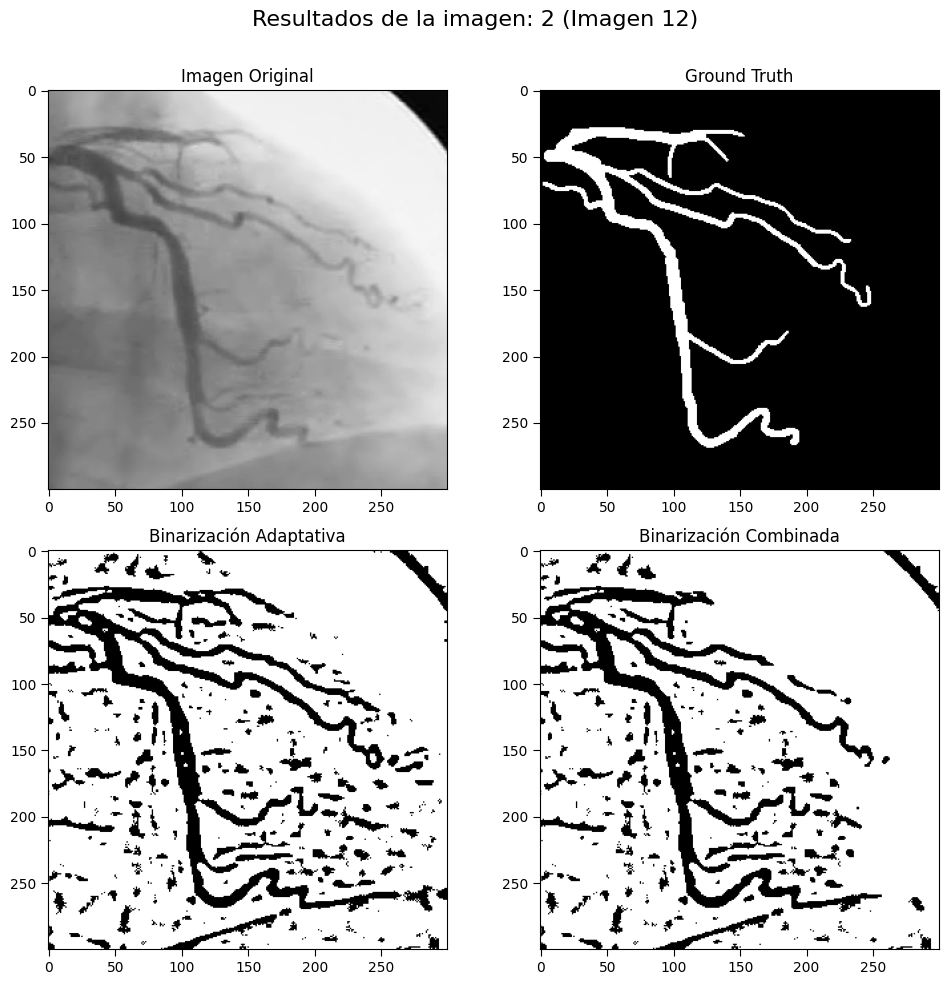

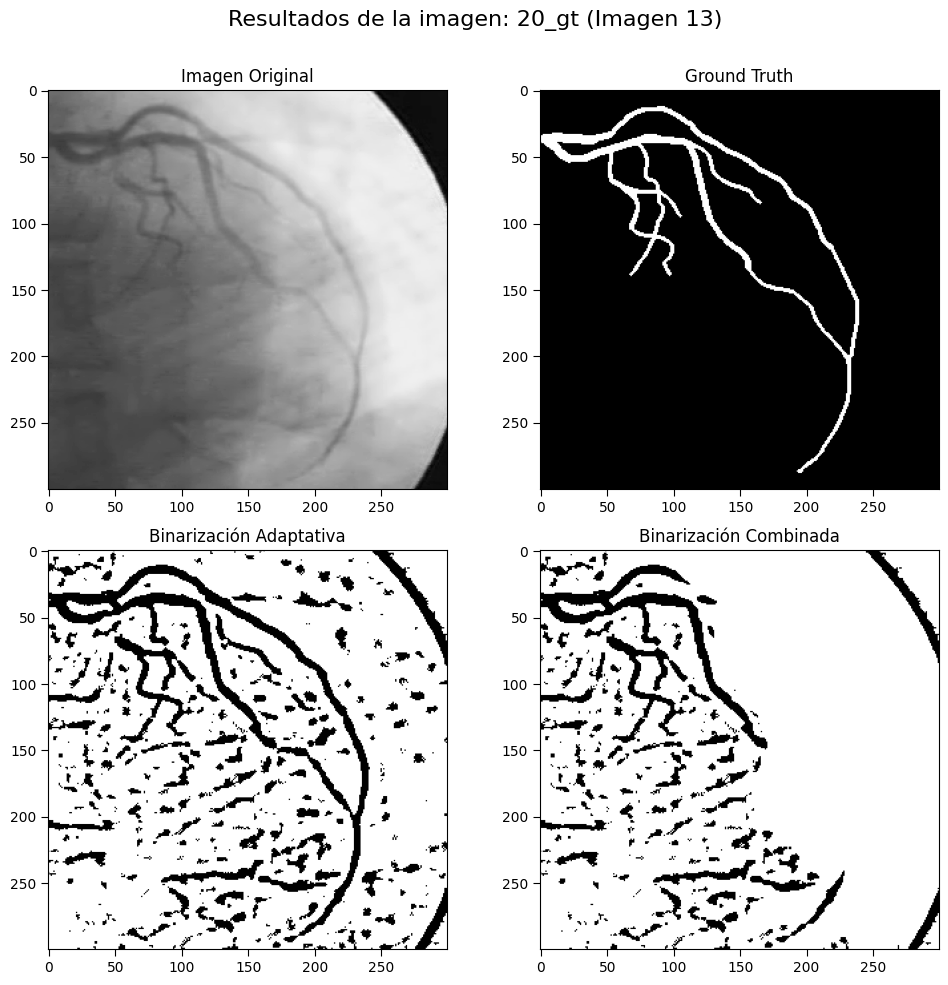

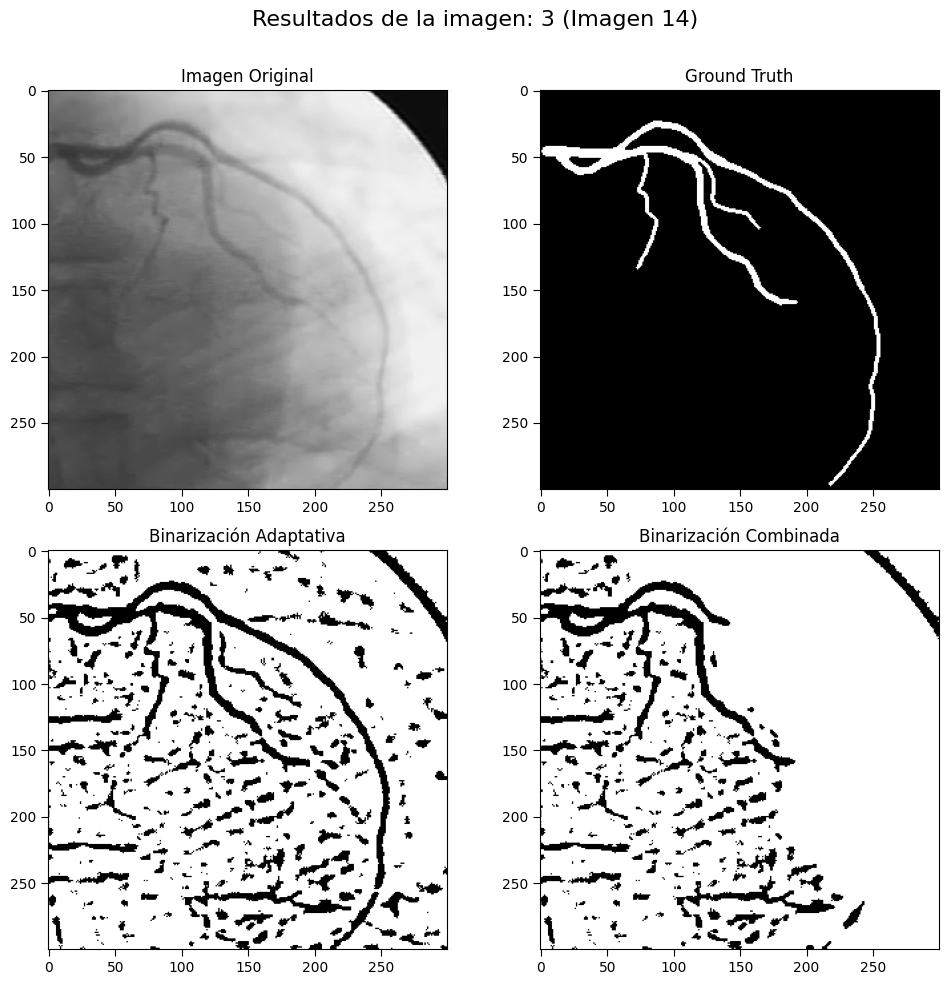

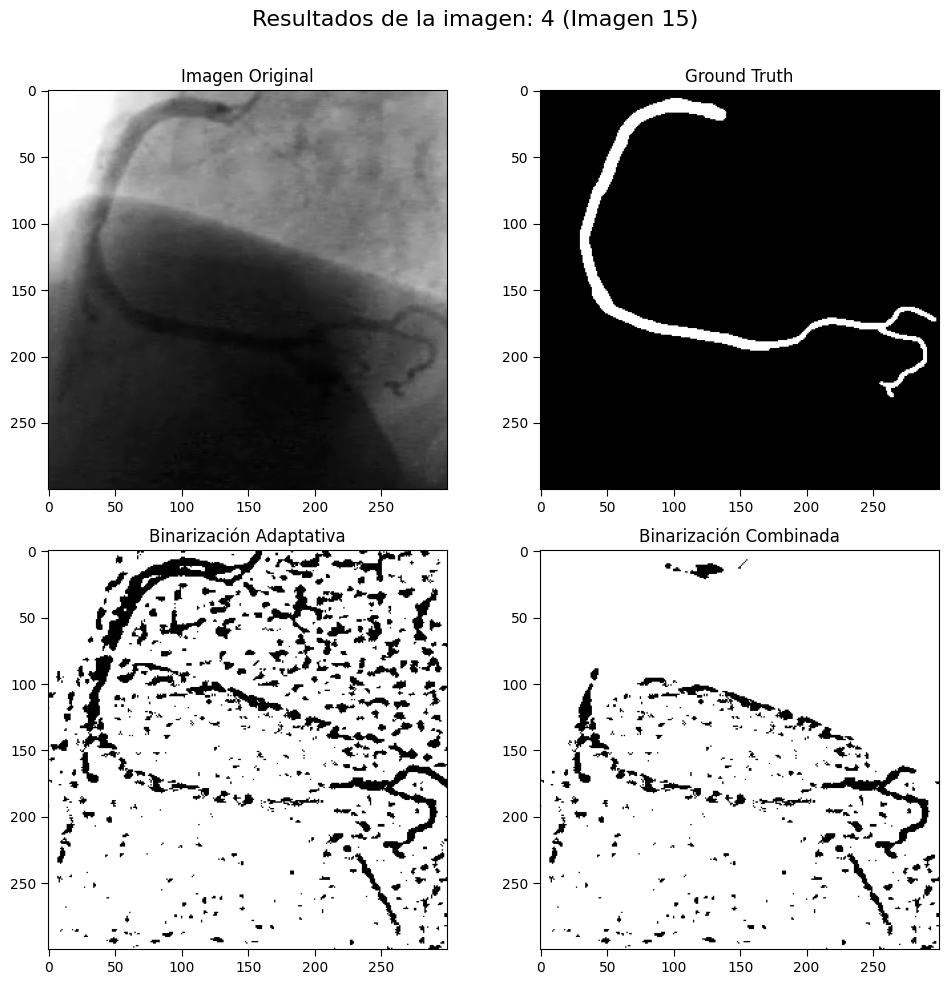

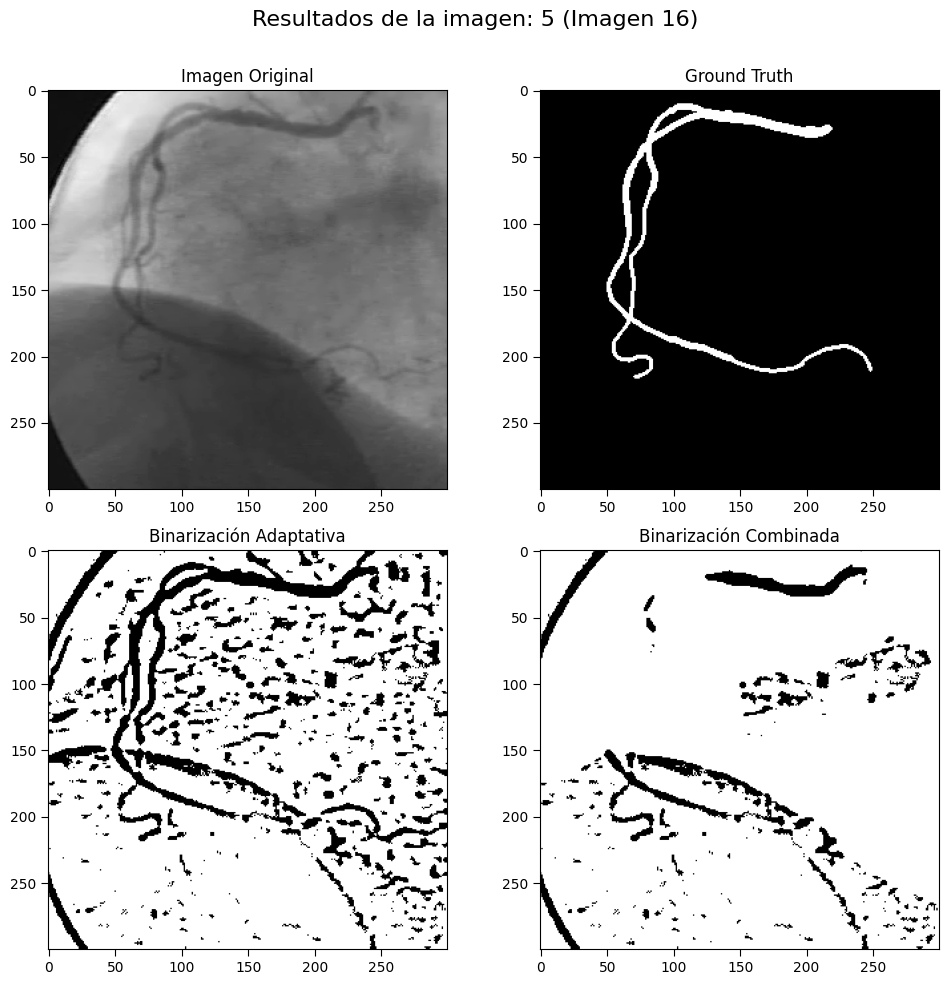

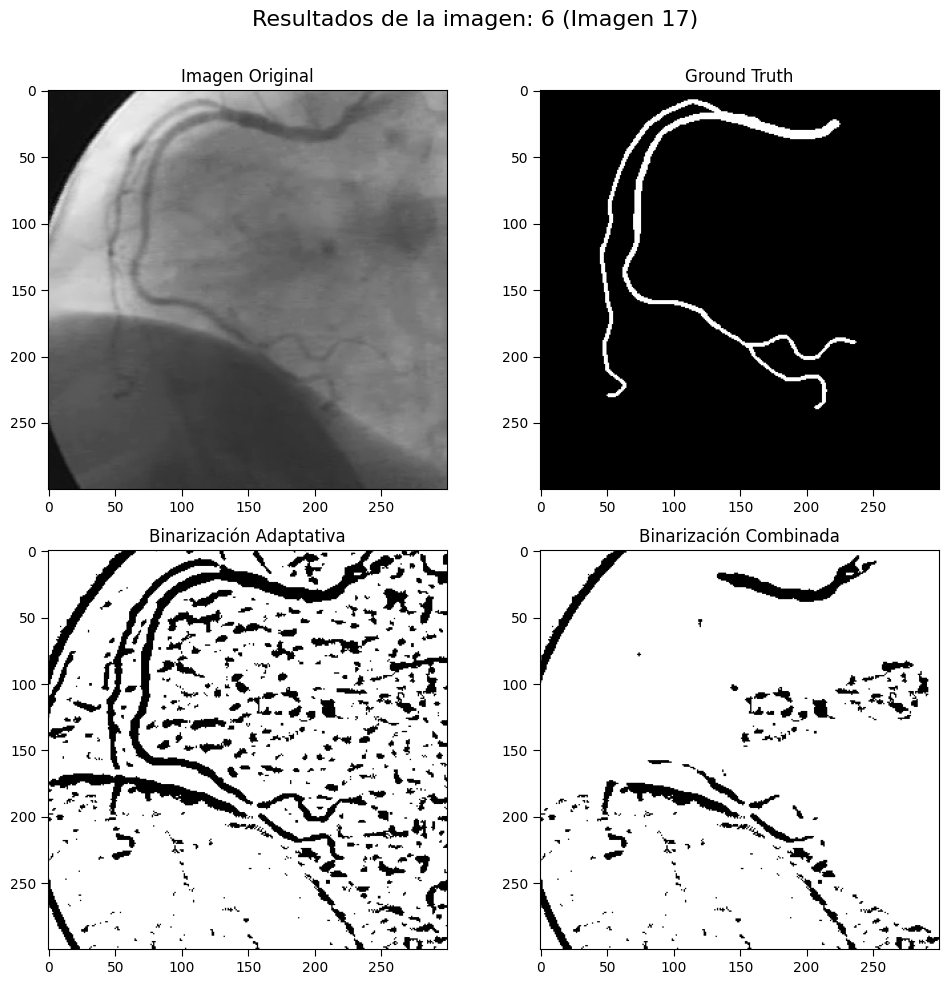

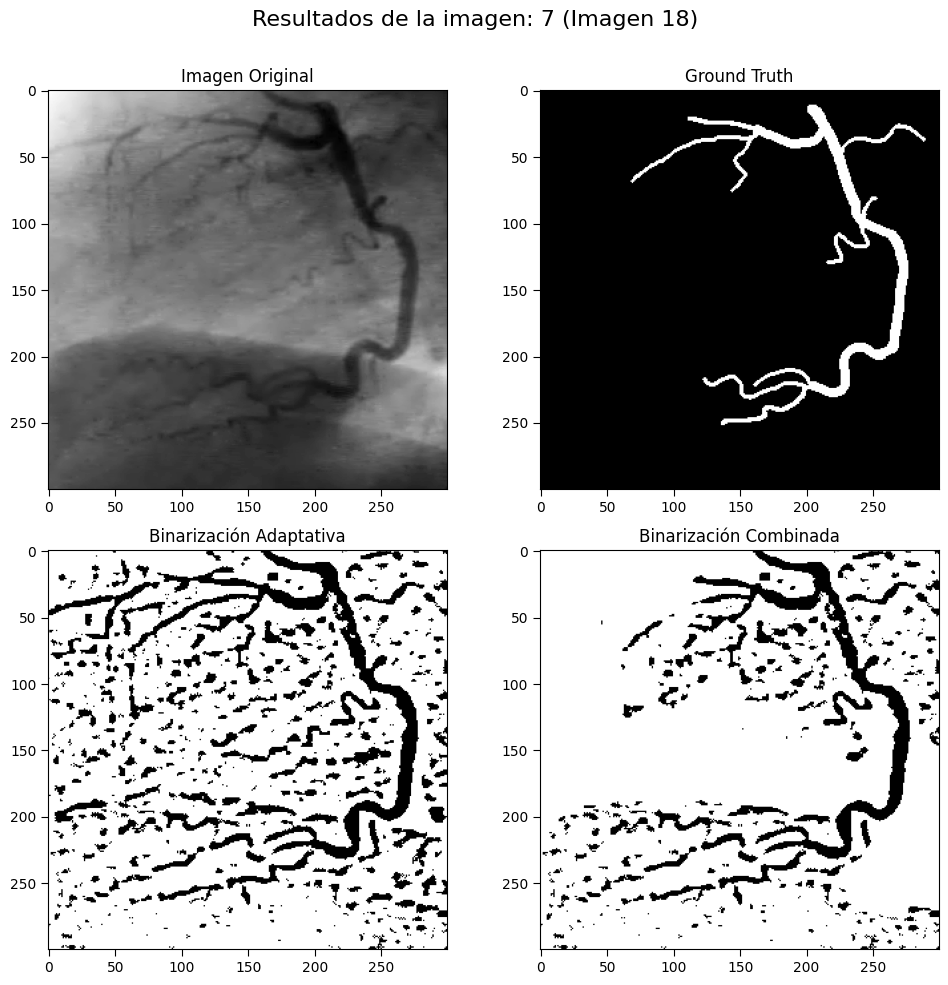

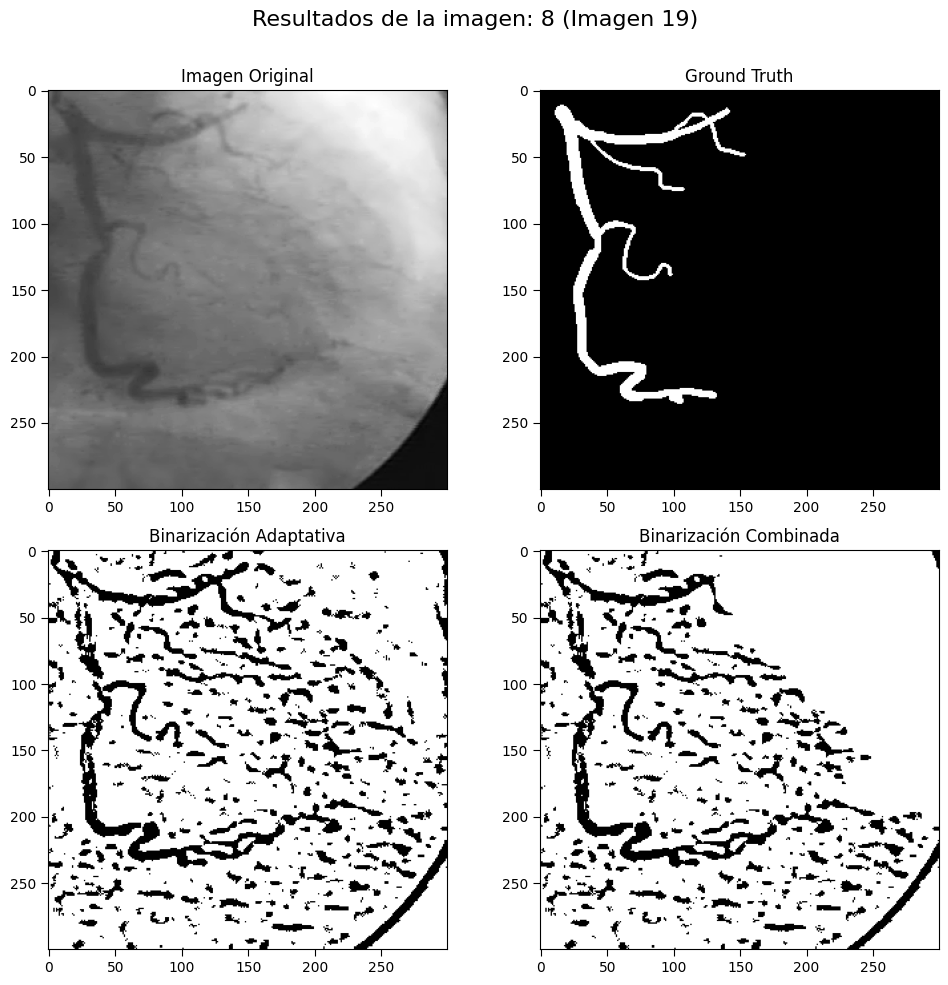

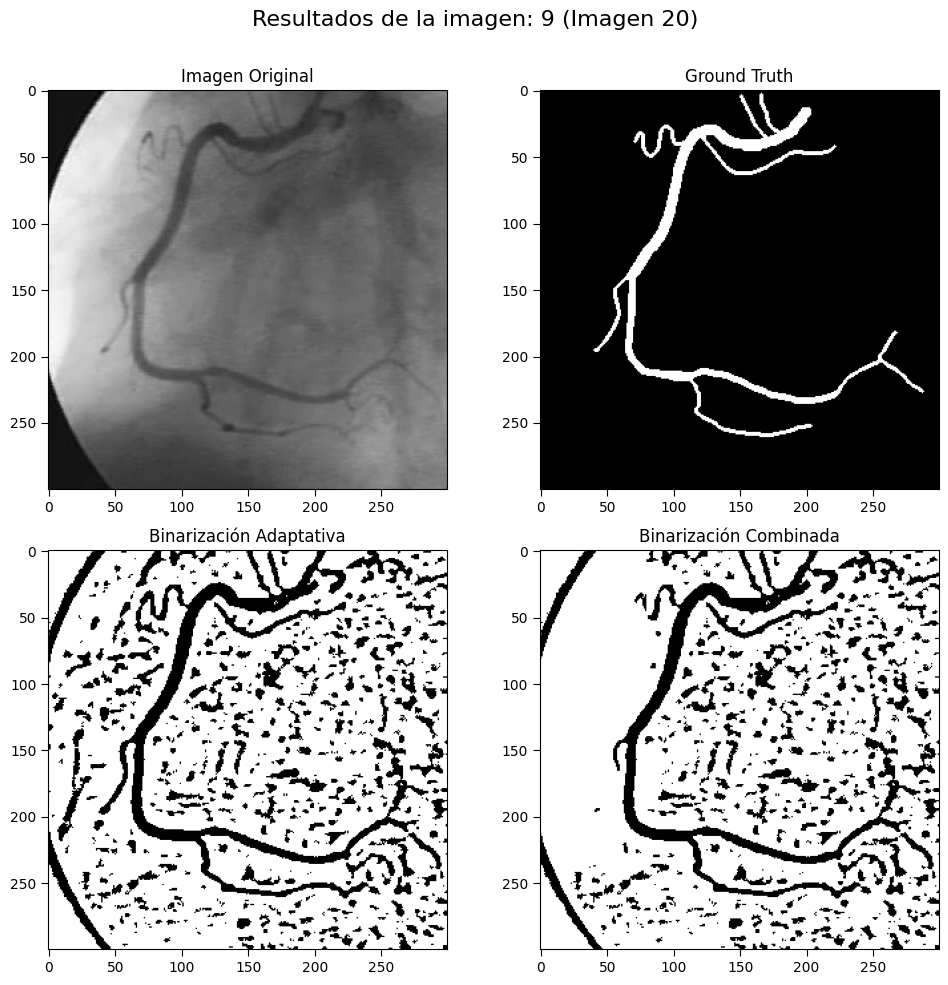

In [ ]:
# MOSTRAR RESULTADOS
def mostrar_resultados(imagen, groundtruth, binarizada_adaptativa, binarizada_combinada, nombre_imagen, indice):
    fig, ax = plt.subplots(2, 2, figsize=(10, 10))
    fig.suptitle(f"Resultados de la imagen: {nombre_imagen} (Imagen {indice})", fontsize=16)

    # Imagen original
    ax[0, 0].imshow(imagen, cmap="gray")
    ax[0, 0].set_title("Imagen Original")
    ax[0, 0].axis('on')
    ax[0, 0].tick_params(axis='both', which='both', length=5)

    # Ground Truth
    ax[0, 1].imshow(groundtruth, cmap="gray")
    ax[0, 1].set_title("Ground Truth")
    ax[0, 1].axis('on') 
    ax[0, 1].tick_params(axis='both', which='both', length=5)

    # Binarización Adaptativa
    ax[1, 0].imshow(binarizada_adaptativa, cmap="gray")
    ax[1, 0].set_title("Binarización Adaptativa")
    ax[1, 0].axis('on') 
    ax[1, 0].tick_params(axis='both', which='both', length=5)

    # Binarización Combinada
    ax[1, 1].imshow(binarizada_combinada, cmap="gray")
    ax[1, 1].set_title("Binarización Combinada")
    ax[1, 1].axis('on') 
    ax[1, 1].tick_params(axis='both', which='both', length=5)

    plt.tight_layout()
    plt.subplots_adjust(top=0.9)  
    plt.show()

# Recorrer todas las imágenes
for i in range(len(imagenes)):
    imagen = imagenes[i]
    groundtruth = groundtruths[i]
    
    # Obtener el nombre de la imagen (sin el "_gt.pgm")
    imagen_nombre = os.path.basename(archivos[2*i]).replace(".pgm", "")  # 2*i porque la imagen y la groundtruth están alternadas
    
    # Realizar binarizaciones
    binarizada_adaptativa = binarizacion_adaptativa(imagen)
    binarizada_combinada = binarizacion_combinada(imagen)
    
    # Mostrar los resultados
    mostrar_resultados(imagen, groundtruth, binarizada_adaptativa, binarizada_combinada, imagen_nombre, i+1)
